# "Cross-validation" des modèles

In [16]:
learning_rate = 0.04
num_epochs = 400
N = 100
N_cv = 40
seed = 42
batch_size = N//4
batch_size = N//2

N_test = 0
N_test = 1000
N_scan = 9

In [17]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [18]:
def get_data(
            N = N,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y


In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Linear(1, 1) 

    def forward(self, x):
        p0 = torch.sigmoid(self.logit0(torch.zeros(1)))
        out = p0/2 + (1-p0)*torch.sigmoid(self.linear(x))
        return out

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [20]:
%%timeit
theta, p, y = get_data()

35.1 µs ± 276 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0 - Loss: 0.74658
Iteration: 12 - Loss: 0.70168
Iteration: 24 - Loss: 0.67667
Iteration: 36 - Loss: 0.64930
Iteration: 48 - Loss: 0.60561
Iteration: 60 - Loss: 0.55318
Iteration: 72 - Loss: 0.51078
Iteration: 84 - Loss: 0.48309
Iteration: 96 - Loss: 0.46533
Iteration: 108 - Loss: 0.45355
Iteration: 120 - Loss: 0.44573
Iteration: 132 - Loss: 0.44043
Iteration: 144 - Loss: 0.43656
Iteration: 156 - Loss: 0.43365
Iteration: 168 - Loss: 0.43162
Iteration: 180 - Loss: 0.43033
Iteration: 192 - Loss: 0.42896
Iteration: 204 - Loss: 0.42815
Iteration: 216 - Loss: 0.42753
Iteration: 228 - Loss: 0.42699
Iteration: 240 - Loss: 0.42663
Iteration: 252 - Loss: 0.42640
Iteration: 264 - Loss: 0.42615
Iteration: 276 - Loss: 0.42600
Iteration: 288 - Loss: 0.42586
Iteration: 300 - Loss: 0.42573
Iteration: 312 - Loss: 0.42564
Iteration: 324 - Loss: 0.42556
Iteration: 336 - Loss: 0.42546
Iteration: 348 - Loss: 0.42542
Iteration: 360 - Loss: 0.42547
Iteration: 372 - Loss: 0.42533
Iteration: 384 - L

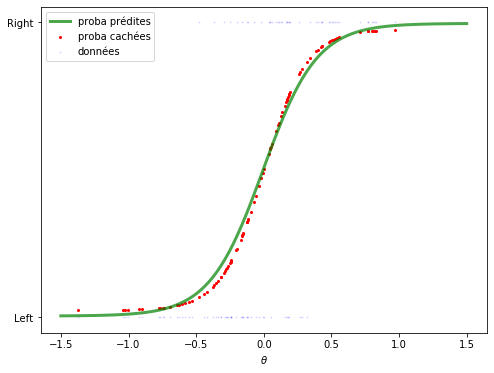

In [22]:
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [23]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

1.58 s ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.4252, grad_fn=<BinaryCrossEntropyBackward>)


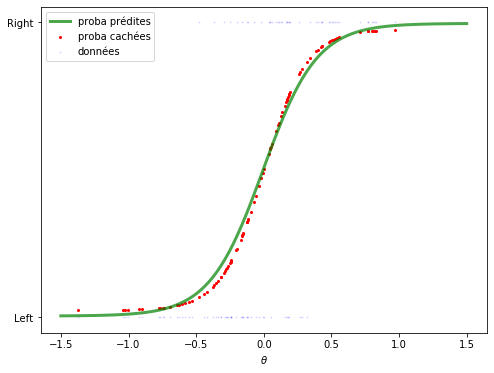

In [24]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [ ]:
Ns = np.logspace(1, 3, N_scan, base=10)
Ns_, losses, KLs, KL0s = [], [], [], []
for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item() 
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, KL: {KL:.5f}, KL0: {KL0:.5f}")
        KL0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        KL0s.append(KL0)
        Ns_.append(N_)
        KLs.append(KL)
        losses.append(loss)

N: 10, Loss: 0.51580, KL: 0.50106
N: 17, Loss: 0.44249, KL: 0.43726
N: 31, Loss: 0.38880, KL: 0.39468
N: 56, Loss: 0.38349, KL: 0.39312
N: 100, Loss: 0.38519, KL: 0.39127
N: 177, Loss: 0.38679, KL: 0.38963


In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, KLs, alpha=3/N_cv, label='KL')
ax.plot(Ns_, KL0s, alpha=3/N_cv, label='KL0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [12]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, KLs, KL0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, KL: {KL:.5f}, KL0: {KL0:.5f}")
        learning_rates_.append(learning_rate_)
        KL0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        KL0s.append(KL0)
        KLs.append(KL)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.53331, KL: 0.53579
learning_rate: 0.00711, Loss: 0.42925, KL: 0.43299
learning_rate: 0.01265, Loss: 0.40381, KL: 0.40849
learning_rate: 0.02249, Loss: 0.38685, KL: 0.39229
learning_rate: 0.04000, Loss: 0.38529, KL: 0.39142
learning_rate: 0.07113, Loss: 0.38519, KL: 0.39162
learning_rate: 0.12649, Loss: 0.38544, KL: 0.39200
learning_rate: 0.22494, Loss: 0.38522, KL: 0.39196
learning_rate: 0.40000, Loss: 0.38546, KL: 0.39224


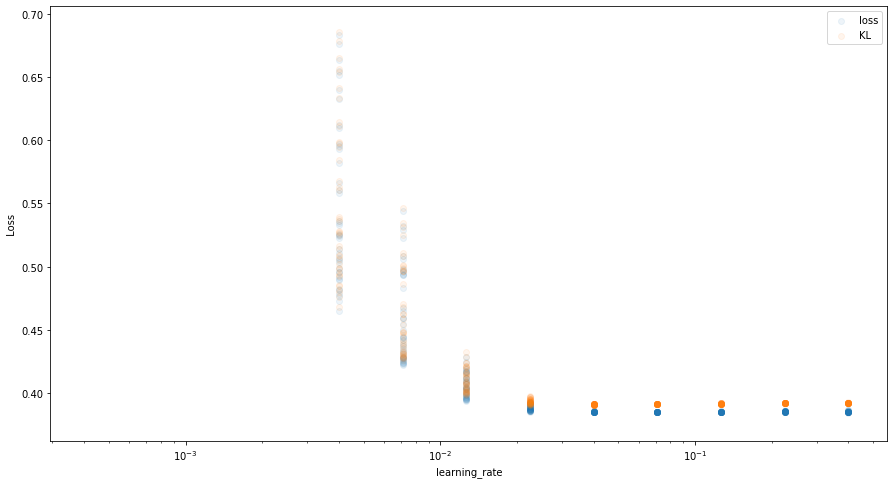

In [13]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, KLs, alpha=3/N_cv, label='KL')
ax.plot(learning_rates_, KL0s, alpha=3/N_cv, label='KL0')

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [14]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, KLs, KL0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, KL: {KL:.5f}, KL0: {KL0:.5f}")
        num_epochss_.append(num_epochs_)
        KL0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        KL0s.append(KL0)
        KLs.append(KL)
        losses.append(loss)

num_epochs: 40, Loss: 0.54589, KL: 0.54825
num_epochs: 71, Loss: 0.51254, KL: 0.51527
num_epochs: 126, Loss: 0.41419, KL: 0.41840
num_epochs: 224, Loss: 0.38725, KL: 0.39289
num_epochs: 400, Loss: 0.38494, KL: 0.39077
num_epochs: 711, Loss: 0.38530, KL: 0.39174
num_epochs: 1264, Loss: 0.38535, KL: 0.39209
num_epochs: 2249, Loss: 0.38546, KL: 0.39227
num_epochs: 4000, Loss: 0.38543, KL: 0.39232


AttributeError: 'list' object has no attribute 'min'

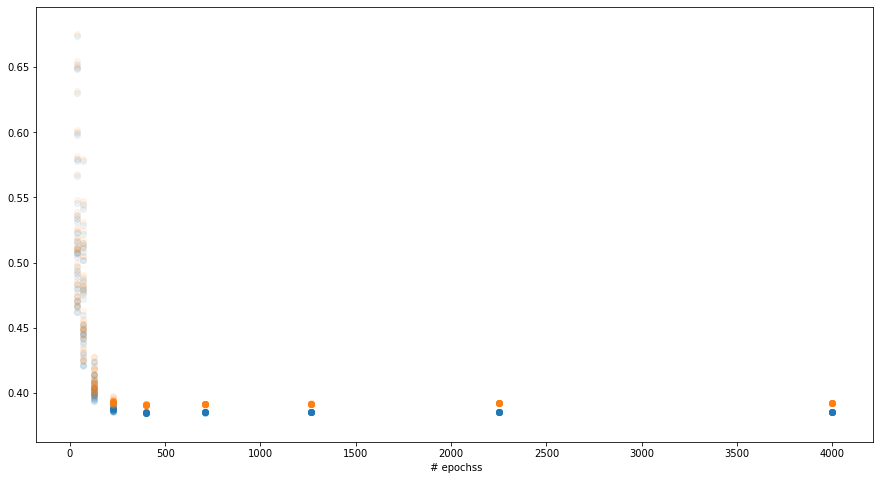

In [15]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, KLs, alpha=3/N_cv, label='KL')
ax.plot(num_epochss_, KL0s, alpha=3/N_cv, label='KL0')

ax.set_xlabel(' # epochss')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [ ]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, KLs, KL0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        KL = criterion(outputs, torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, KL: {KL:.5f}, KL0: {KL0:.5f}")
        batch_sizes_.append(batch_size_)
        KL0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        KL0s.append(KL0)
        KLs.append(KL)
        losses.append(loss)

In [ ]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, KLs, alpha=3/N_cv, label='KL')
ax.plot(batch_sizes_, KL0s, alpha=3/N_cv, label='KL0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');